# 01. Data Quality Analysis and Cleaning (Fixed)
"""
This script is a fixed version of the data quality notebook, with robust handling for missing values visualization.
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

In [3]:
# Load raw data
df = pd.read_csv('../Synthetic_ESG_Greenwashing_Dataset_200_v2.csv')
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (200, 18)


,project_id,organization_name,report_year,esg_claim_text,claim_category,claimed_metric_type,claimed_value,measurement_unit,project_location,actual_measured_value,value_deviation,external_validation_score,greenwashing_flag,controversy_flag,source_doc_link,report_sentiment_score,llm_claim_consistency_score,timestamp
0,SP-PROJ-0000,Acciona Renewables,2018,"In 2018, Acciona Renewables reported board div...",Governance,exec_comp_tied_to_esg,50.0,%,USA,58.82,8.82,81.0,0,0,https://example.com/esg-reports/SP-PROJ-0000,0.40,0.70,2024-10-03T12:19:10Z
1,SP-PROJ-0001,Acciona Renewables,2019,"In 2019, Acciona Renewables reported local com...",Social,community_investment,10.0,million USD,Canada,11.87,1.87,60.3,0,0,https://example.com/esg-reports/SP-PROJ-0001,0.24,0.89,2024-12-20T12:19:10Z
2,SP-PROJ-0002,Iberdrola Green Energy,2024,"In 2024, Iberdrola Green Energy reported local...",Social,supplier_diversity,2.0,million USD,South Africa,1.98,-0.02,81.2,0,0,https://example.com/esg-reports/SP-PROJ-0002,0.59,0.69,2025-04-11T12:19:10Z
3,SP-PROJ-0003,Repsol Low Carbon,2022,"In 2022, Repsol Low Carbon reported board dive...",Governance,board_independence,60.0,%,Canada,64.57,4.57,76.8,0,0,https://example.com/esg-reports/SP-PROJ-0003,-0.13,0.45,2024-09-22T12:19:10Z
4,SP-PROJ-0004,Acciona Renewables,2018,"In 2018, Acciona Renewables reported training ...",Social,supplier_diversity,20.0,million USD,India,20.89,0.89,80.0,0,0,https://example.com/esg-reports/SP-PROJ-0004,0.78,0.84,2025-05-15T12:19:10Z


In [4]:
# 1. Data Schema Validation
print("Data Types:")
print(df.dtypes)
print("\nDataset Info:")
print(df.info())

Data Types:
project_id                      object
organization_name               object
report_year                      int64
esg_claim_text                  object
claim_category                  object
claimed_metric_type             object
claimed_value                  float64
measurement_unit                object
project_location                object
actual_measured_value          float64
value_deviation                float64
external_validation_score      float64
greenwashing_flag                int64
controversy_flag                 int64
source_doc_link                 object
report_sentiment_score         float64
llm_claim_consistency_score    float64
timestamp                       object
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   project_id                   20

In [5]:
expected_columns = [
    'project_id', 'organization_name', 'report_year', 'esg_claim_text',
    'claim_category', 'claimed_metric_type', 'claimed_value', 'measurement_unit',
    'project_location', 'actual_measured_value', 'value_deviation',
    'external_validation_score', 'greenwashing_flag', 'controversy_flag',
    'source_doc_link', 'report_sentiment_score', 'llm_claim_consistency_score', 'timestamp'
]

In [6]:
missing_columns = set(expected_columns) - set(df.columns)
extra_columns = set(df.columns) - set(expected_columns)
print(f"\nMissing columns: {missing_columns}")
print(f"Extra columns: {extra_columns}")
print(f"All expected columns present: {len(missing_columns) == 0}")


Missing columns: set()
Extra columns: set()
All expected columns present: True


In [7]:
# 2. Missing Values Analysis
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percent': missing_percent
})

In [8]:
print("Missing Values Analysis:")
missing_columns = missing_df[missing_df['Missing Count'] > 0]
print(missing_columns)

Missing Values Analysis:
Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []



✅ No missing values found in the dataset!
This is excellent data quality - no missing value visualization needed.


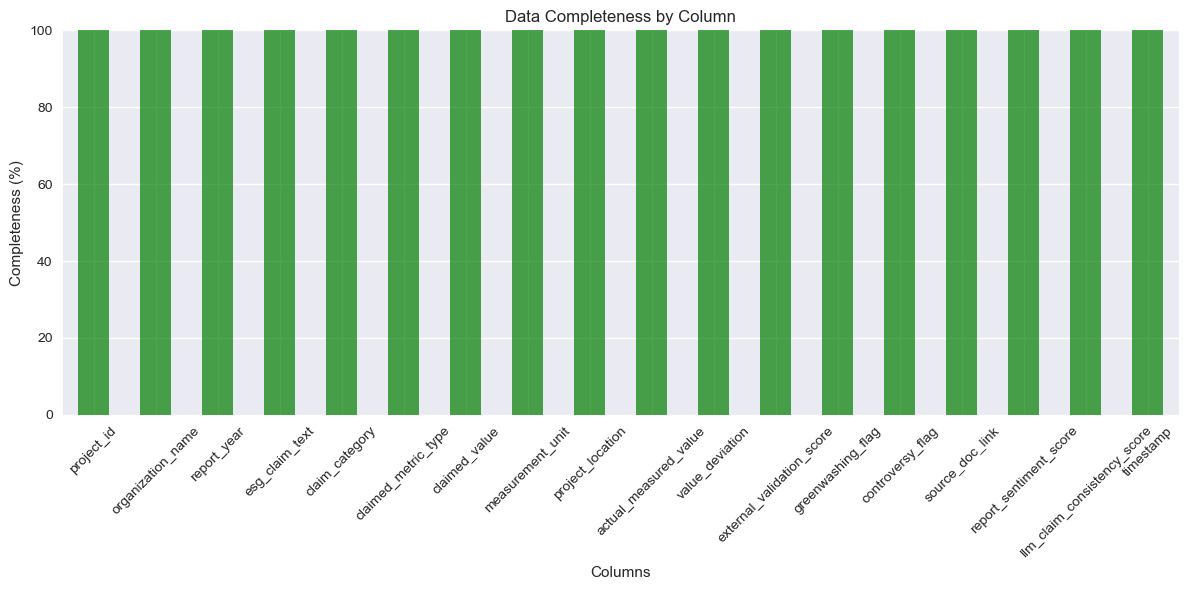

In [9]:
# Visualize missing values only if there are any
if len(missing_columns) > 0:
    plt.figure(figsize=(12, 6))
    missing_columns['Missing Percent'].plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../reports/figures/missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\n✅ No missing values found in the dataset!")
    print("This is excellent data quality - no missing value visualization needed.")
    # Optionally, show completeness
    plt.figure(figsize=(12, 6))
    completeness = (1 - missing_percent/100) * 100
    completeness.plot(kind='bar', color='green', alpha=0.7)
    plt.title('Data Completeness by Column')
    plt.xlabel('Columns')
    plt.ylabel('Completeness (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig('../reports/figures/data_completeness.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
# 3. Duplicate Detection
duplicates = df.duplicated().sum()
key_columns = ['project_id', 'esg_claim_text']
duplicates_key = df.duplicated(subset=key_columns).sum()
print(f"Total duplicate rows: {duplicates}")
print(f"Duplicate rows based on {key_columns}: {duplicates_key}")
if duplicates > 0:
    print("\nDuplicate rows:")
    print(df[df.duplicated()])
else:
    print("\n✅ No duplicate rows found.")

Total duplicate rows: 0
Duplicate rows based on ['project_id', 'esg_claim_text']: 0

✅ No duplicate rows found.


Text Length Statistics:
       text_length  word_count
count   200.000000  200.000000
mean     77.570000   11.380000
std       8.007854    1.149874
min      60.000000    9.000000
25%      71.000000   11.000000
50%      78.000000   11.000000
75%      84.000000   12.000000
max      96.000000   14.000000


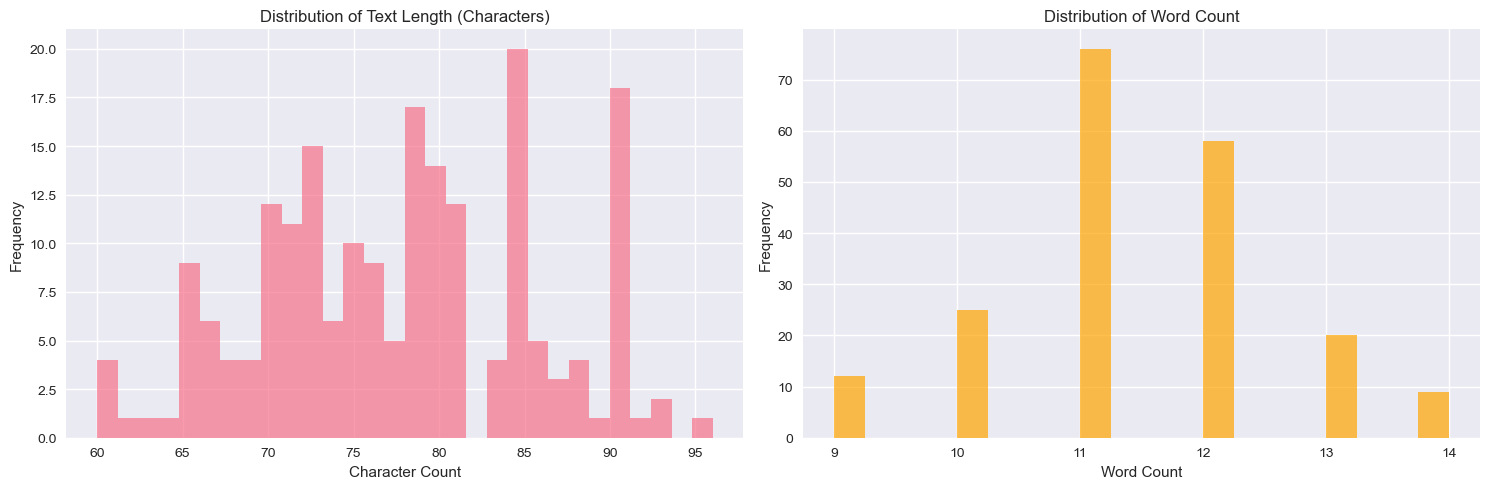


Texts with < 50 characters: 0
Texts with > 500 characters: 0

✅ No very short texts found.


In [11]:
# 4. Text Quality Analysis
df['text_length'] = df['esg_claim_text'].str.len()
df['word_count'] = df['esg_claim_text'].str.split().str.len()
print("Text Length Statistics:")
print(df[['text_length', 'word_count']].describe())
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(df['text_length'], bins=30, alpha=0.7)
axes[0].set_title('Distribution of Text Length (Characters)')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[1].hist(df['word_count'], bins=20, alpha=0.7, color='orange')
axes[1].set_title('Distribution of Word Count')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('../reports/figures/text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
short_texts = df[df['text_length'] < 50]
long_texts = df[df['text_length'] > 500]
print(f"\nTexts with < 50 characters: {len(short_texts)}")
print(f"Texts with > 500 characters: {len(long_texts)}")
if len(short_texts) > 0:
    print("\nSample short texts:")
    print(short_texts['esg_claim_text'].head())
else:
    print("\n✅ No very short texts found.")

In [12]:
# 5. Data Cleaning
df_clean = df.copy()
df_clean = df_clean.drop_duplicates()
print(f"Removed {len(df) - len(df_clean)} duplicate rows")
df_clean['esg_claim_text'] = df_clean['esg_claim_text'].str.strip()
df_clean['esg_claim_text'] = df_clean['esg_claim_text'].fillna('No claim text provided')
df_clean = df_clean[df_clean['esg_claim_text'].str.len() >= 10]
print(f"Removed {len(df) - len(df_clean)} rows with very short texts")
remaining_missing = df_clean.isnull().sum().sum()
print(f"\nRemaining missing values: {remaining_missing}")

Removed 0 duplicate rows
Removed 0 rows with very short texts

Remaining missing values: 0


In [13]:
# 6. Feature Engineering
import sys
sys.path.append('../src')
from data_prep import engineer_features
df_features = engineer_features(df_clean)
print(f"Original features: {len(df_clean.columns)}")
print(f"Engineered features: {len(df_features.columns)}")
print(f"Feature engineering added: {len(df_features.columns) - len(df_clean.columns)} new features")
original_cols = set(df_clean.columns)
new_cols = set(df_features.columns) - original_cols
print(f"\nNew engineered features: {list(new_cols)}")
missing_in_features = df_features.isnull().sum()
if missing_in_features.sum() > 0:
    print("\nMissing values in engineered features:")
    print(missing_in_features[missing_in_features > 0])
else:
    print("\n✅ No missing values in engineered features")

INFO:data_prep:Engineering features...
INFO:data_prep:Feature engineering complete


Original features: 20
Engineered features: 28
Feature engineering added: 8 new features

New engineered features: ['month', 'year', 'claim_category_encoded', 'project_location_encoded', 'deviation_pct', 'avg_score', 'deviation_abs', 'claimed_metric_type_encoded']

✅ No missing values in engineered features


In [14]:
# 7. Data Quality Metrics
quality_metrics = {
    'original_rows': int(len(df)),
    'cleaned_rows': int(len(df_clean)),
    'rows_removed': int(len(df) - len(df_clean)),
    'duplicates_removed': int(len(df) - len(df.drop_duplicates())),
    'missing_values_original': int(df.isnull().sum().sum()),
    'missing_values_cleaned': int(df_clean.isnull().sum().sum()),
    'text_length_min': int(df_clean['esg_claim_text'].str.len().min()),
    'text_length_max': int(df_clean['esg_claim_text'].str.len().max()),
    'text_length_mean': float(df_clean['esg_claim_text'].str.len().mean()),
    'unique_organizations': int(df_clean['organization_name'].nunique()),
    'unique_locations': int(df_clean['project_location'].nunique()),
    'category_distribution': df_clean['claim_category'].value_counts().to_dict(),
    'greenwashing_rate': float(df_clean['greenwashing_flag'].mean())
}
import json
with open('../reports/data_quality_metrics.json', 'w') as f:
    json.dump(quality_metrics, f, indent=2)
print("\nQuality metrics saved to ../reports/data_quality_metrics.json")


Quality metrics saved to ../reports/data_quality_metrics.json


In [15]:
# 8. Save Cleaned Data
os.makedirs('../data', exist_ok=True)
df_clean.to_parquet('../data/clean_claims.parquet', index=False)
df_features.attrs = {}  # Remove non-serializable attrs
df_features.to_parquet('../data/clean_claims_features.parquet', index=False)
print("Cleaned data saved:")
print("- ../data/clean_claims.parquet (cleaned original data)")
print("- ../data/clean_claims_features.parquet (with engineered features)")
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
print(f"Final features dataset shape: {df_features.shape}")
print("\nSample of cleaned data:")
print(df_clean.head())

Cleaned data saved:
- ../data/clean_claims.parquet (cleaned original data)
- ../data/clean_claims_features.parquet (with engineered features)

Final cleaned dataset shape: (200, 20)
Final features dataset shape: (200, 28)

Sample of cleaned data:
     project_id       organization_name  report_year  \
0  SP-PROJ-0000      Acciona Renewables         2018   
1  SP-PROJ-0001      Acciona Renewables         2019   
2  SP-PROJ-0002  Iberdrola Green Energy         2024   
3  SP-PROJ-0003       Repsol Low Carbon         2022   
4  SP-PROJ-0004      Acciona Renewables         2018   

                                      esg_claim_text claim_category  \
0  In 2018, Acciona Renewables reported board div...     Governance   
1  In 2019, Acciona Renewables reported local com...         Social   
2  In 2024, Iberdrola Green Energy reported local...         Social   
3  In 2022, Repsol Low Carbon reported board dive...     Governance   
4  In 2018, Acciona Renewables reported training ...         

In [16]:
# 9. Summary
print("=== DATA QUALITY ANALYSIS SUMMARY ===\n")
print("1. DATA CLEANING RESULTS:")
print(f"   - Original rows: {quality_metrics['original_rows']}")
print(f"   - Cleaned rows: {quality_metrics['cleaned_rows']}")
print(f"   - Rows removed: {quality_metrics['rows_removed']}")
print(f"   - Duplicates removed: {quality_metrics['duplicates_removed']}")
print("\n2. MISSING VALUES:")
print(f"   - Original missing values: {quality_metrics['missing_values_original']}")
print(f"   - Remaining missing values: {quality_metrics['missing_values_cleaned']}")
print("\n3. TEXT QUALITY:")
print(f"   - Text length range: {quality_metrics['text_length_min']} - {quality_metrics['text_length_max']} characters")
print(f"   - Average text length: {quality_metrics['text_length_mean']:.1f} characters")
print("\n4. DATASET CHARACTERISTICS:")
print(f"   - Unique organizations: {quality_metrics['unique_organizations']}")
print(f"   - Unique locations: {quality_metrics['unique_locations']}")
print(f"   - Greenwashing rate: {quality_metrics['greenwashing_rate']:.2%}")
print("\n5. FEATURE ENGINEERING:")
print(f"   - Original features: {len(df_clean.columns)}")
print(f"   - Engineered features: {len(df_features.columns)}")
print(f"   - New features added: {len(df_features.columns) - len(df_clean.columns)}")
print("\n6. NEXT STEPS:")
print("   - Data is ready for exploratory analysis")
print("   - Features are prepared for model training")
print("   - Proceed to notebook 02_eda.ipynb for detailed analysis") 

=== DATA QUALITY ANALYSIS SUMMARY ===

1. DATA CLEANING RESULTS:
   - Original rows: 200
   - Cleaned rows: 200
   - Rows removed: 0
   - Duplicates removed: 0

2. MISSING VALUES:
   - Original missing values: 0
   - Remaining missing values: 0

3. TEXT QUALITY:
   - Text length range: 60 - 96 characters
   - Average text length: 77.6 characters

4. DATASET CHARACTERISTICS:
   - Unique organizations: 15
   - Unique locations: 10
   - Greenwashing rate: 38.00%

5. FEATURE ENGINEERING:
   - Original features: 20
   - Engineered features: 28
   - New features added: 8

6. NEXT STEPS:
   - Data is ready for exploratory analysis
   - Features are prepared for model training
   - Proceed to notebook 02_eda.ipynb for detailed analysis
